## 실시간 그래프 기반으로 VRP 수행

In [1]:
import osmnx as ox
from geopy.distance import geodesic
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import folium
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
import lightgbm as lgb
from datetime import datetime, timedelta
import folium

from ortools.constraint_solver import pywrapcp, routing_enums_pb2

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## Data Load

In [ ]:
cctv_df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/CCTV기반단속개별건수', encoding='cp949')
normal_df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/일반단속개별건수_geocoded.csv', encoding='cp949')

train_size = 0.7
val_size = 0.15
test_size = 0.15
seed = 42

# test set 분리
cctv_train_val, cctv_test   = train_test_split(cctv_df,   test_size=test_size, random_state=seed)
norm_train_val, norm_test   = train_test_split(normal_df, test_size=test_size, random_state=seed)

# train/val 비율 재계산
val_ratio = val_size / (train_size + val_size)

# train/val set 분리
cctv_train, cctv_val = train_test_split(cctv_train_val, test_size=val_ratio, random_state=seed)
norm_train, norm_val = train_test_split(norm_train_val, test_size=val_ratio, random_state=seed)

# 서초구 CCTV 정보
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
seocho_cctv = cctv_info[cctv_info['소재지도로명주소'].str.contains("서초구", na=False)]
seocho_cctv.rename(columns={"WGS84위도" : '위도', 'WGS84경도' : '경도'}, inplace=True)

c:\Users\chobh\AppData\Local\anaconda3\envs\bigProject\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\chobh\AppData\Local\Temp\ipykernel_19164\2021845063.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seocho_cctv.rename(columns={"WGS84위도" : '위도', 'WGS84경도' : '경도'}, inplace=True)


In [5]:
def count_viloations_per_node(df, G):
    '''
    일반 단속 데이터를 이용해 각 그래프 노드 별 단속 건수 집계 함수
    '''

    # 그래프 노드 위치 정보
    nodes = ox.graph_to_gdfs(G, edges=False)
    node_coords = np.array(list(zip(nodes['y'], nodes['x'])))
    tree = cKDTree(node_coords)

    # 단속 위치 -> 최근접 노드 매핑
    df = df.dropna(subset=['위도', '경도'])
    coords = df[['위도', '경도']].values
    _, idx = tree.query(coords, k=1)
    nearest_node_ids = nodes.iloc[idx].index

    # 노드별 건수 집계
    violation_counts = pd.Series(nearest_node_ids).value_counts().to_dict()

    return violation_counts

def compute_cctv_detection_weights(detection_log, G, now_time, l=0.1):
    """
    CCTV 기반 탐지 이력을 기반으로 그래프 노드별 탐지 중요도 계산
    l : 감소 속도 파라미터
    """
    now_time = pd.to_datetime(now_time)

    # 그래프 노드 위치 정보
    nodes = ox.graph_to_gdfs(G, edges=False)
    node_coords = np.array(list(zip(nodes['y'], nodes['x'])))
    tree = cKDTree(node_coords)

    # 유효탐지 로그 필터링
    df = detection_log.copy()
    df['단속일시'] = pd.to_datetime(df['단속일시'], errors='coerce')
    df = df.dropna(subset=['위도', '경도', '단속일시'])
    df = df[df['단속일시'] <= now_time]

    if df.empty:
        print("탐지 로그가 현재 시각 이전 데이터가 없습니다.")
        return {}

    # 위치 -> 최근접 노드 매핑
    coords =  df[['위도', '경도']].values
    _, idx = tree.query(coords, k=1)
    nearest_node_ids = nodes.iloc[idx].index
    df['node_id'] = nearest_node_ids

    # 시간 가중치 계산 (최근일수록 높게)
    df['time_diff'] = (now_time - df['단속일시']).dt.total_seconds() / 3600  # 단위: 시간
    df['weight'] = np.exp(-l * df['time_diff'])

    # 노드별 가중치 합산
    node_weights = df.groupby('node_id')['weight'].sum().to_dict()

    return node_weights

In [66]:
# 그래프 및 각 가중치 로딩
now = '2023-06-28 14:33:00'
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')
G = ox.distance.add_edge_lengths(G) # 실 거리 추가
violation_counts = count_viloations_per_node(norm_train, G)
cctv_node_weights = compute_cctv_detection_weights(cctv_train, G, now, l=0.001)

In [18]:
def normalize_dict(input_dict):
    """
    입력: {node_id: count or weight}
    출력: {node_id: normalized_value} (0~1 정규화)
    """
    if not input_dict:
        return {}

    index = list(input_dict.keys())
    values = list(input_dict.values())

    scaler = MinMaxScaler()
    norm_values = scaler.fit_transform(pd.DataFrame(values))

    return {node: float(norm) for node, norm in zip(index, norm_values.flatten())}

def integrate_weights(graph, violation_count_dict, real_time_weight_dict, alpha=0.2, beta=0.8):
    """
    violation_count_dict: {node_id: count}
    real_time_weight_dict: {node_id: weight}
    alpha: 누적 위반 빈도 중요도 계수
    beta: 실시간 탐지 중요도 계수

    반환값:
    - 가중치가 추가된 graph
    - 통합 weight 정보를 포함한 DataFrame
    """
    # 정규화
    norm_violation = normalize_dict(violation_count_dict)
    norm_real_time = normalize_dict(real_time_weight_dict)

    # 통합 노드 집합
    all_nodes = list(set(norm_violation.keys()) | set(norm_real_time.keys()))

    # DataFrame 생성
    df = pd.DataFrame(index=all_nodes)
    df["norm_violation"] = pd.Series(norm_violation)
    df["norm_real_time"] = pd.Series(norm_real_time)

    # 결측값 처리
    df.fillna(0, inplace=True)

    # 최종 가중치 계산
    df["final_weight"] = alpha * df["norm_violation"] + beta * df["norm_real_time"]

    # 그래프 노드에 final_weight 속성으로 할당
    for node in graph.nodes():
        graph.nodes[node]["final_weight"] = df["final_weight"].get(node, 0.0)

    return graph, df


In [19]:
search_graph, weight_df = integrate_weights(G, violation_counts, cctv_node_weights)

In [ ]:
# 시각화 함수
def plot_graph_by_final_weight(graph, figsize=(10, 10), node_size=10, edge_linewidth=0.5, cmap_name='Reds'):
    """
    final_weight 속성을 기반으로 노드 색상 시각화
    """
    # final_weight 추출
    weights = nx.get_node_attributes(graph, "final_weight")
    if not weights:
        print("그래프에 'final_weight' 속성이 존재하지 않습니다.")
        return

    nodes = list(weights.keys())
    values = list(weights.values())

    # 색상 정규화
    norm = colors.Normalize(vmin=min(values), vmax=max(values))
    cmap = cm.get_cmap(cmap_name)

    # 좌표 정보 추출
    pos = {node: (graph.nodes[node]['x'], graph.nodes[node]['y']) for node in nodes if 'x' in graph.nodes[node] and 'y' in graph.nodes[node]}

    # 시각화 시작
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # 도로(edge) 그리기
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_linewidth, alpha=0.5, ax=ax)

    # 노드 그리기
    node_colors = [cmap(norm(weights[n])) for n in pos.keys()]
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_colors, ax=ax)

    # 컬러바 추가
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Final Weight", color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    ax.set_title("Graph Nodes Colored by Final Weight", color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\chobh\AppData\Local\Temp\ipykernel_19164\2009052807.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


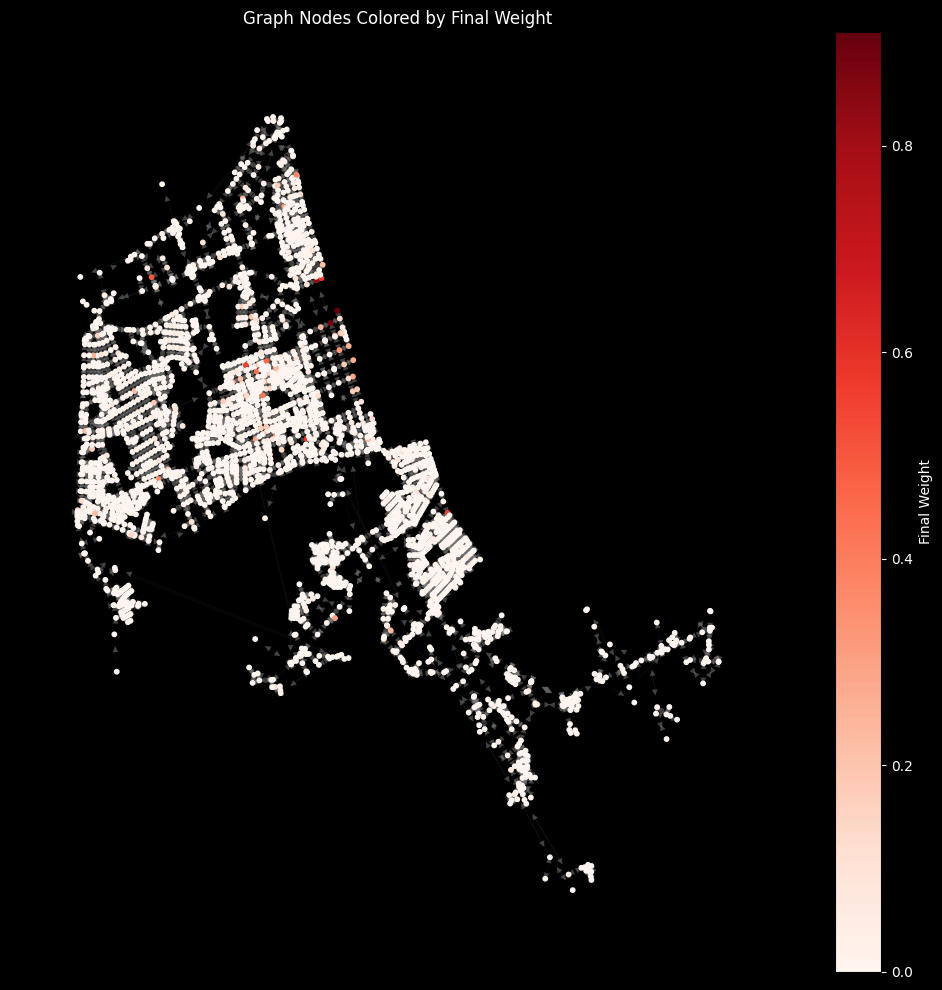

In [27]:
plot_graph_by_final_weight(search_graph, node_size=10, edge_linewidth=0.1)

## calculate edge distance

In [67]:
# 도로망 거리 계산
def get_network_distance(G, u, v):
    return nx.shortest_path_length(G, source=u, target=v, weight='length')  # meter

def compute_all_pair_distances(G, nodes=None):
    """
    모든 노드쌍 간 도로망 거리 계산
    반환: {(u,v): 거리}
    """
    if nodes is None:
        nodes = list(G.nodes)

    distance_dict = {}
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if u == v:
                continue
            try:
                dist = nx.shortest_path_length(G, u, v, weight='length')
                distance_dict[(u, v)] = dist
            except nx.NetworkXNoPath:
                distance_dict[(u, v)] = float("inf")
        if i % 10 == 0:
            print(f"{i+1}/{len(nodes)} nodes 완료")

    return distance_dict

In [70]:
def solve_orienteering_with_ortools(G, num_vehicles=1, max_distance=5000):
    """
    G: osmnx 기반 그래프 (node에 final_weight, edge에 length 포함)
    num_vehicles: 단속 차량 수
    max_distance: 차량 1대당 최대 이동 거리 (미터 기준)
    """
    # 1. 노드 리스트 및 인덱스 매핑
    nodes = list(G.nodes)
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes)}
    index_to_node_id = {i: node_id for i, node_id in enumerate(nodes)}
    N = len(nodes)

    # 2. 거리 행렬 생성 (edge['length'] 기반 최단 거리)
    distance_matrix = np.full((N, N), np.inf)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if u == v:
                distance_matrix[i][j] = 0
            else:
                try:
                    dist = nx.shortest_path_length(G, source=u, target=v, weight='length')
                    distance_matrix[i][j] = dist
                except nx.NetworkXNoPath:
                    continue
    distance_matrix = distance_matrix.astype(int).tolist()

    # 3. final_weight → profit 점수로 변환
    profits = [int(G.nodes[n].get('final_weight', 0.0) * 1000) for n in nodes]

    # 4. OR-tools 모델 정의
    manager = pywrapcp.RoutingIndexManager(N, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # 거리 비용 콜백
    def distance_callback(from_idx, to_idx):
        from_node = manager.IndexToNode(from_idx)
        to_node = manager.IndexToNode(to_idx)
        return distance_matrix[from_node][to_node]
    transit_cb_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_index)

    # 거리 제한 차원 추가
    routing.AddDimension(
        transit_cb_index,
        0, max_distance,  # no slack, max distance
        True,             # start cumul at zero
        "Distance"
    )

    # 노드 이득(disjunction with negative penalty)
    for idx, profit in enumerate(profits):
        if profit > 0:
            routing.AddDisjunction([manager.NodeToIndex(idx)], -profit)

    # 5. 옵션 설정 및 탐색
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.FromSeconds(30)

    # 6. 최적해 탐색
    solution = routing.SolveWithParameters(search_parameters)

    if not solution:
        print("해를 찾지 못했습니다.")
        return None

    # 7. 결과 디코딩
    routes = []
    total_profit = 0
    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        route = []
        route_profit = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            node_id = index_to_node_id[node_index]
            route.append(node_id)
            route_profit += profits[node_index]
            index = solution.Value(routing.NextVar(index))
        route.append(index_to_node_id[manager.IndexToNode(index)])  # 도착점
        routes.append(route)
        total_profit += route_profit

    return {
        "routes": routes,
        "total_profit": total_profit / 1000.0  # 스케일 되돌리기
    }


In [ ]:
result = solve_orienteering_with_ortools(G, num_vehicles=3, max_distance=8000)

for i, route in enumerate(result["routes"]):
    print(f"[차량 {i+1}] 방문 경로: {route}")
print(f"총 단속 이득(final_weight 합): {result['total_profit']:.2f}")


## VPR Graph build V2

In [2]:
# 그래프 데이터 생성
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type="drive")
G = ox.distance.add_edge_lengths(G) # 실 거리 추가

nodes = ox.graph_to_gdfs(G, edges=False)

# kd-tree 구축
coords = np.vstack((nodes['y'], nodes['x'])).T
tree = cKDTree(coords)

def map_to_nearest_node(lat, lon):
    _, idx = tree.query([lat, lon])
    return nodes.index[idx]


In [3]:
# 데이터 load 및 전처리
path_cctv = '../../../Data/서초구주정차단속및CCTV정제데이터/CCTV기반단속개별건수.csv'
path_report = '../../../Data/서초구주정차단속및CCTV정제데이터/일반단속개별건수_geocoded.csv'

df_cctv = pd.read_csv(path_cctv, encoding='cp949')
df_report = pd.read_csv(path_report, encoding='cp949')

for df in (df_cctv, df_report):
    df['단속일시'] = pd.to_datetime(df['단속일시'], errors='coerce')
    
# 결측치 제거
df_cctv = df_cctv.dropna(subset=['단속일시', '위도', '경도']).reset_index(drop=True)
df_report = df_report.dropna(subset=['단속일시', '위도', '경도']).reset_index(drop=True)

df_cctv['node'] = df_cctv.apply(lambda r: map_to_nearest_node(r['위도'], r['경도']), axis=1)
df_report['node'] = df_report.apply(lambda r: map_to_nearest_node(r['위도'], r['경도']), axis=1)

In [4]:
# data split

TEST_DAYS = 15  # 테스트용 기간
VAL_DAYS  = 30  # 검증용 기간

max_time = max(df_cctv['단속일시'].max(), df_report['단속일시'].max())

split_test_time  = max_time - pd.Timedelta(days=TEST_DAYS)
split_val_time   = split_test_time - pd.Timedelta(days=VAL_DAYS)

def assign_period(ts):
    if ts <= split_val_time:
        return 'train'
    elif ts <= split_test_time:
        return 'val'
    else:
        return 'test'

df_cctv['period']   = df_cctv['단속일시'].apply(assign_period)
df_report['period'] = df_report['단속일시'].apply(assign_period)

cols_keep = ['단속일시', '위도', '경도', 'period', 'node']
df_cctv = df_cctv[cols_keep]
df_report = df_report[cols_keep]

train_all = pd.concat([df_cctv[df_cctv['period'] == 'train'].assign(source='cctv'), df_report[df_report['period'] == 'train'].assign(source='report')], ignore_index=True)

train_all.head(3)

,단속일시,위도,경도,period,node,source
0,2022-01-01 08:00:00,37.4892,126.9936,train,2623456118,cctv
1,2022-01-01 08:02:00,37.4934,127.0124,train,2368063910,cctv
2,2022-01-01 08:02:00,37.4934,127.0125,train,2368063910,cctv


In [5]:

# train_all['node'] = train_all.apply(
#     lambda r: map_to_nearest_node(r['위도'], r['경도']),
#     axis=1
# )

In [6]:
# 노드별 cosine-decay 가중치 집계 및 후보 필터링

# 기준 시각
now_time = split_val_time

# cosine decay 파라미터
T_minutes = 24 * 60 # 시간 단위 (분)
min_nodes = 10 # 최소 후보 노드 수
max_nodes = 100 # 최대 후보 노드 수
q = 0.8 # 초기 백분위
q_step = 0.01 # 조정 스텝


# cosine decay weight 계산 (분 단위)

train_all['delta_m'] = (now_time - train_all['단속일시']).dt.total_seconds() / 60.0

# 비율 계산
ratio = np.minimum(train_all['delta_m'] / T_minutes, 1.0)
train_all['weight'] = 0.5 * (1 + np.cos(np.pi * ratio))

# 노드별 weight 합산 및 정규화
node_weights = train_all.groupby('node')['weight'].sum()
node_weights = node_weights / node_weights.max()

# 백분위 기반 후보 추출 (min_nodes 이상 확보)
while True:
    threshold = node_weights.quantile(q)
    candidates = node_weights[node_weights >= threshold]
    if len(candidates) < min_nodes and q > 0:
        q = max(q - q_step, 0.0)
    else:
        break

# max_nodes 초과 시 상위 슬라이싱
if len(candidates) > max_nodes:
    candidates = candidates.sort_values(ascending=False).head(max_nodes)

# 후보 노드 리스트 및 속성 테이블
candidate_nodes = candidates.index.tolist()
node_coords = nodes.loc[candidate_nodes, ['y','x']].rename(columns={'y':'lat','x':'lon'})
node_reward = candidates.rename('reward')

In [7]:
# 서초구청 기준으로 탐색 대상 노드 구성

office_lat, office_lon = 37.483323, 127.032539
office_node = map_to_nearest_node(office_lat, office_lon)

# all node 리스트 구성
# 첫번째가 depot(서초구청), 뒤에 cosine-decay 후보 노드

all_nodes = [office_node] + candidate_nodes

n = len(all_nodes)
# all nodes 인덱스 매핑
node_to_idx = {node : idx for idx, node in enumerate(all_nodes)}

distance_matrix = [[0]*n for _ in range(n)]

# 각 출발 노드마다 G에서 최단 경로 계산

for source_node in all_nodes:
    lengths = nx.single_source_dijkstra_path_length(
        G, source_node, weight='length'
    )
    i = node_to_idx[source_node]
    for target_node in all_nodes:
        j = node_to_idx[target_node]
        # lengths에 없으면 매우 큰 값(차단) 혹은 직접 연결 불가
        dist_m = int(lengths.get(target_node, 10**9))
        distance_matrix[i][j] = dist_m
        
# or-tools 데이터 딕셔너리 수정
data = {
    'distance_matrix': distance_matrix,
    'num_vehicles': 1,
    'starts': [0],   # all_nodes[0] == office_node
    'ends':   [0],   # same
    'rewards': node_reward.reindex(all_nodes).tolist(),  # all_nodes 순서로 정렬
    'max_distance': 50000,  # 최대 순회 거리 50km → 50000m
}

# RoutingModel 생성 & 비용, 제약 설정
manager = pywrapcp.RoutingIndexManager(
    len(data['distance_matrix']),
    data['num_vehicles'],
    data['starts'],
    data['ends']
)
routing = pywrapcp.RoutingModel(manager)

# 거리 callback
def distance_callback(from_index, to_index):
    i = manager.IndexToNode(from_index)
    j = manager.IndexToNode(to_index)
    return data['distance_matrix'][i][j]
dist_cb = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

# 거리제약 dimension
routing.AddDimension(
    dist_cb,
    slack_max=0,
    capacity=data['max_distance'],  # m 단위
    fix_start_cumul_to_zero=True,
    name='Distance'
)

# Reward 기반 방문 유도
for idx in range(1, n):
    node_index = manager.NodeToIndex(idx)
    penalty = int((1 - data['rewards'][idx]) * 1000)
    routing.AddDisjunction([node_index], penalty)

# 탐색 파라미터
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_params.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_params.time_limit.seconds = 10
search_params.log_search = True


# solve
solution = routing.SolveWithParameters(search_params)

In [8]:
# 1. OR-Tools가 반환한 순서 (예시)
route_nodes = []
idx = routing.Start(0)
while not routing.IsEnd(idx):
    route_nodes.append(all_nodes[manager.IndexToNode(idx)])
    idx = solution.Value(routing.NextVar(idx))
route_nodes.append(all_nodes[manager.IndexToNode(idx)])  # 복귀

# 2. full_path: 실제 도로망 최단경로 노드 시퀀스
full_path = []
for u, v in zip(route_nodes[:-1], route_nodes[1:]):
    segment = nx.shortest_path(G, u, v, weight='length')
    if not full_path:
        full_path.extend(segment)
    else:
        full_path.extend(segment[1:])

# 3. Folium Map 초기화 (서초구청 중심)
m = folium.Map(
    location=[nodes.at[office_node,'y'], nodes.at[office_node,'x']],
    zoom_start=14
)

# 4. 실제 도로망 경로 PolyLine
route_coords = [(nodes.at[n,'y'], nodes.at[n,'x']) for n in full_path]
folium.PolyLine(route_coords, color='blue', weight=4, opacity=0.7).add_to(m)

# 5. 마커 그리기
detect_nodes = set(route_nodes[1:-1])  # 탐지 대상(방문) 노드
for n in full_path:
    coord = (nodes.at[n,'y'], nodes.at[n,'x'])
    if n in detect_nodes:
        # 탐지 대상 노드: 붉은 원
        folium.CircleMarker(coord, radius=6, color='red', fill=True, fill_opacity=0.9).add_to(m)
    else:
        # 경로 상 일반 노드: 초록 작은 점
        folium.CircleMarker(coord, radius=3, color='green', fill=True, fill_opacity=0.6).add_to(m)

# 6. 시작/끝 표시 (서초구청)
office_coord = (nodes.at[office_node,'y'], nodes.at[office_node,'x'])
folium.Marker(office_coord, icon=folium.Icon(color='blue', icon='home')).add_to(m)

# 7. 결과 표시
m

In [57]:
## 시뮬레이션을 통한 성능 평가


# val 데이터 준비


# val/test 이벤트 준비
events = pd.concat([df_cctv[df_cctv['period']=='val'][['node','단속일시']], df_report[df_report['period']=='val'][['node','단속일시']]], ignore_index=True)

# 추천 경로별 도착 시각 시뮬레이션

speed_m_per_min = 500  

# all_nodes 에서 인덱스 맵
node_to_idx = {node: idx for idx,node in enumerate(all_nodes)}

# 시뮬레이트 방문 시각 누적
visit_times = {}  # node → 방문 시각 (minutes since start)
elapsed = 0.0
prev_node = all_nodes[0]  # depot
start_time = split_val_time   # val 시작 시각 or test 시작 시각
visit_times[prev_node] = start_time

for next_node in route_nodes[1:]:
    i, j = node_to_idx[prev_node], node_to_idx[next_node]
    dist_m = distance_matrix[i][j]
    travel_min = dist_m / speed_m_per_min
    elapsed += travel_min
    visit_times[next_node] = start_time + pd.Timedelta(minutes=elapsed)
    prev_node = next_node

# 이벤트 커버 매핑
# 각 실제 이벤트가 “방문 시각 이전”에 커버되었는지 확인
events['pred_time'] = events['node'].map(visit_times)
# events['단속일시'] ≤ events['pred_time'] → 커버
events['covered'] = events['단속일시'] <= events['pred_time']

# 이벤트별 커버 여부
covered_events = events[events['covered']]

KeyError: "['node'] not in index"

In [2]:
path_cctv = '../../../Data/서초구주정차단속및CCTV정제데이터/CCTV기반단속개별건수.csv'
path_report = '../../../Data/서초구주정차단속및CCTV정제데이터/일반단속개별건수_geocoded.csv'

In [13]:
df_cctv = pd.read_csv(path_cctv, encoding='cp949')
df_report = pd.read_csv(path_report, encoding='cp949')

df_cctv['단속일시'] = pd.to_datetime(df_cctv['단속일시'], errors='coerce')
df_report['단속일시'] = pd.to_datetime(df_report['단속일시'], errors='coerce')

df_cctv = df_cctv.dropna(subset=['위도','경도']).reset_index(drop=True)
df_report = df_report.dropna(subset=['위도','경도']).reset_index(drop=True)

display(df_cctv.head(3))
display(df_report.head(3))

,단속일시,과태료 원금,단속동,단속장소_new,코드,지번,위치정보,위반내용,위도,경도
0,2022-01-01 08:00:00,40000,방배4동,방배4동 876-1 세븐일레븐 앞,P21040,방배4동 876-1,세븐일레븐 앞,주차금지(황색점선)구역,37.4892,126.9936
1,2022-01-01 08:02:00,40000,서초3동,서초3동 1715-10 남촌빌딩 주변,N05010,서초3동 1715-10,남촌빌딩 주변,주차금지(황색점선)구역,37.4934,127.0124
2,2022-01-01 08:02:00,40000,서초3동,서초3동 1715-10 남촌빌딩 주변,N05010,서초3동 1715-10,남촌빌딩 주변,주차금지(황색점선)구역,37.4934,127.0125


,단속일시,과태료 원금,단속동,단속장소,위반내용,full_address,위도,경도
0,2022-01-01 00:02:00,40000,서초동,서울특별시 서초구 반포대로22길 73 (서초동),주정차금지(황색실선)구역,서울특별시 서초구 반포대로22길 73,37.490810,127.012357
1,2022-01-01 00:03:00,40000,서초동,서울특별시 서초구 반포대로22길 73 (서초동),주정차금지(황색실선)구역,서울특별시 서초구 반포대로22길 73,37.490810,127.012357
2,2022-01-01 00:11:00,40000,방배동,서울특별시 서초구 효령로25길 59 (방배동),주정차금지(황색실선)구역,서울특별시 서초구 효령로25길 59,37.483602,126.992976


In [14]:
# 전체 데이터 기준 최대/최소 시각
max_time = max(df_cctv['단속일시'].max(), df_report['단속일시'].max())
min_time = min(df_cctv['단속일시'].min(), df_report['단속일시'].min())

# 검증기간 길이
val_days = 30
split_time = max_time - pd.Timedelta(days=val_days)

# cctv 로그 분할
df_cctv['period'] = df_cctv['단속일시'].apply(lambda t: 'train' if t <= split_time else 'val')
df_report['period'] = df_report['단속일시'].apply(lambda t: 'train' if t <= split_time else 'val')

# 분할 결과 확인
print('CCTV 로그 분할 건수 : ',  df_cctv['period'].value_counts())
print('일반단속 로그 분할 건수 : ', df_report['period'].value_counts())

CCTV 로그 분할 건수 :  period
train    156614
val        7068
Name: count, dtype: int64
일반단속 로그 분할 건수 :  period
train    134423
val        6432
Name: count, dtype: int64


In [ ]:
# 서초구 도로 그래프

G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type="drive")

# 노드만 GeoDataFrame으로 변환
nodes = ox.graph_to_gdfs(G, edges=False)

# kd-tree를 위한 좌표 배열 : [[lat, lon], ...]
coords = np.vstack((nodes['y'].values, nodes['x'].values)).T
tree = cKDTree(coords)

# cctv 로그
df_cctv['node'] = df_cctv[['위도', '경도']].apply(lambda row: map_to_nearest_node(row['위도'], row['경도']),axis=1)
# 일반 단속 로그
df_report['node'] = df_report[['위도', '경도']].apply(lambda row: map_to_nearest_node(row['위도'], row['경도']),axis=1)

#확인
print(df_cctv.groupby(['period', 'node']).size().head())
print(df_report.groupby(['period', 'node']).size().head())

period  node     
train   357824648    422
        414683494    371
        414684345     45
        414684380     74
        414684605    303
dtype: int64
period  node     
train   357824648    42
        414683494     8
        414684234    76
        414684235    17
        414684236    18
dtype: int64


In [18]:
# train 로그만 필터
train_cctv = df_cctv[df_cctv['period'] == 'train']
train_report = df_report[df_report['period'] == 'train']

# 두 로그 합치기
train_all = pd.concat([train_cctv.assign(source="cctv"),train_report.assign(source="report")], ignore_index=True)

# 노드별 카운트 집계
node_counts = train_all.groupby("node").size().rename("count")

#노드 확인 및 시각화
print(node_counts.sort_values(ascending=False).head(10))

node
12741729343    6371
2281095534     4357
2477265735     4027
4944067989     3925
3825549664     3677
3088424085     3484
3011682726     3319
8489268383     2979
3827547993     2699
2368063910     2541
Name: count, dtype: int64


In [25]:
# 지수 감쇠 가중치 스코어
# lam (decay rate) 설정 : 예: 반감기(t₁/₂) 6시간 → λ = ln(2) / 6

# 기준 시각 : train 기준 마지막 시점
now_time = split_time

half_life_h = 1
lam = np.log(2) / half_life_h

# 이벤트별 가중치 컬럼 추가
train_all["delta_h"] = (now_time - train_all['단속일시'].fillna(train_all['단속일시'])).dt.total_seconds() / 3600.0
train_all["weight"] = np.exp(-lam * train_all["delta_h"])

# 노드별 가중치 합산
node_decay = train_all.groupby("node")["weight"].sum().rename("decay_score")

# 스코어 정규화
score_df = pd.concat([node_counts, node_decay], axis=1).fillna(0)
score_df["count_norm"] = score_df["count"] / score_df["count"].max()
score_df["decay_norm"] = score_df["decay_score"] / score_df["decay_score"].max()

In [29]:
# 시간대 보정

train_all['hour'] = train_all['단속일시'].dt.hour      # 0–23
train_all['weekday'] = train_all['단속일시'].dt.weekday   # 0=월, …, 6=일

# 노드별 시간, 요일 분포 계산
node_time = (train_all.groupby(['node','weekday','hour']).size().rename('cnt').reset_index())
total_per_node = node_time.groupby('node')['cnt'].transform('sum')
node_time['P'] = node_time['cnt'] / total_per_node

# 현재 시간대 보정 계수 계산
now = datetime.now()
cur_w = now.weekday()
cur_h = now.hour

# 현재 요일, 시간대 P 추출
p_cur = node_time.loc[(node_time['weekday']==cur_w) & (node_time['hour']==cur_h),['node','P']].set_index('node')['P']

# 정규화된 보정 계수
C = p_cur / p_cur.max()
C = C.reindex(score_df.index, fill_value=0).rename('time_coeff')

score_df['final_score'] = score_df['decay_norm'] * C

In [46]:
# 공간 스무딩 진행
tree = cKDTree(coords)

# knn 기반 스무딩
# 파라미터 설정
k = 3
alpha = 0.2

# final score 배열 추출
S = score_df['final_score'].reindex(nodes.index).fillna(0).values  # (n_nodes,)

# 각 노드에 대해 k+1 최근접 검색(자기자신 포함)
dists, idxs = tree.query(coords, k=k+1)
neighbor_idxs = idxs[:, 1:]  # shape (n_nodes, k)


# 이웃 스코어 평균 계산
neighbor_means = S[neighbor_idxs].mean(axis=1)  # (n_nodes,)

# 최종 스무딩 스코어 계산
smoothed = alpha * S + (1 - alpha) * neighbor_means

# score_df에 컬럼 추가
score_df['smoothed_score'] = pd.Series(smoothed, index=nodes.index)

# 상위 10개 노드 확인
print(score_df['smoothed_score'].sort_values(ascending=False).head(10))

node
4721392050    0.020644
4314801002    0.020644
3341139593    0.015483
4185715625    0.010646
1430674335    0.010646
4185715633    0.010646
4185715628    0.010646
4185715634    0.007985
2429722072    0.005334
8487538011    0.005202
Name: smoothed_score, dtype: float64


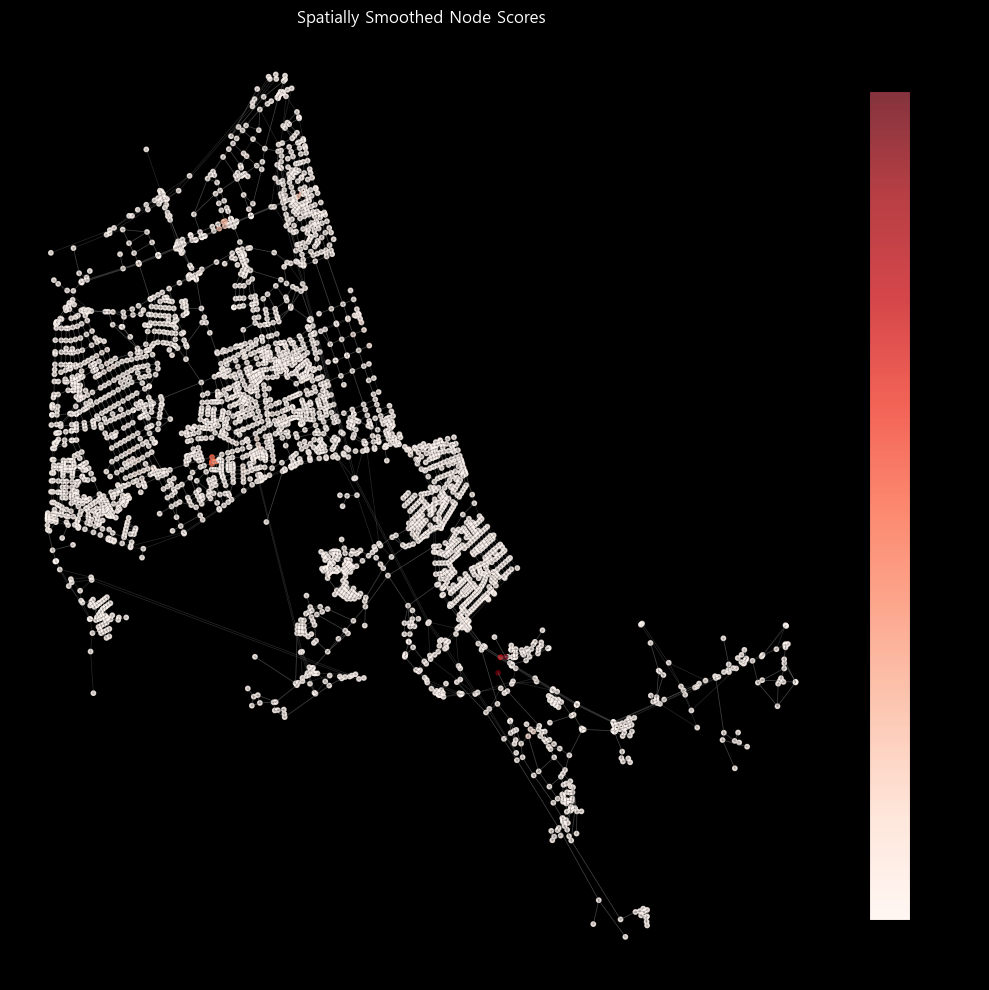

In [47]:
# 시각화

# 노드별 smoothed_score 시각화 (Step 5 예시 코드에서 colors=smoothed)
colors = score_df['smoothed_score'].reindex(nodes.index).fillna(0).values

fig, ax = plt.subplots(figsize=(10,10), facecolor='k')
ax.set_facecolor('k')
for u, v in G.edges():
    x0, y0 = G.nodes[u]['x'], G.nodes[u]['y']
    x1, y1 = G.nodes[v]['x'], G.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5, alpha=0.3)
scatter = ax.scatter(nodes['x'], nodes['y'],
                     c=colors, cmap='Reds', s=10, marker='o', alpha=0.8)
fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04).set_label('Smoothed Score')
ax.set_title('Spatially Smoothed Node Scores', color='white')
ax.axis('off')
plt.tight_layout()
plt.show()


In [45]:
score_df['smoothed_score'].max()

0.015482637536045916

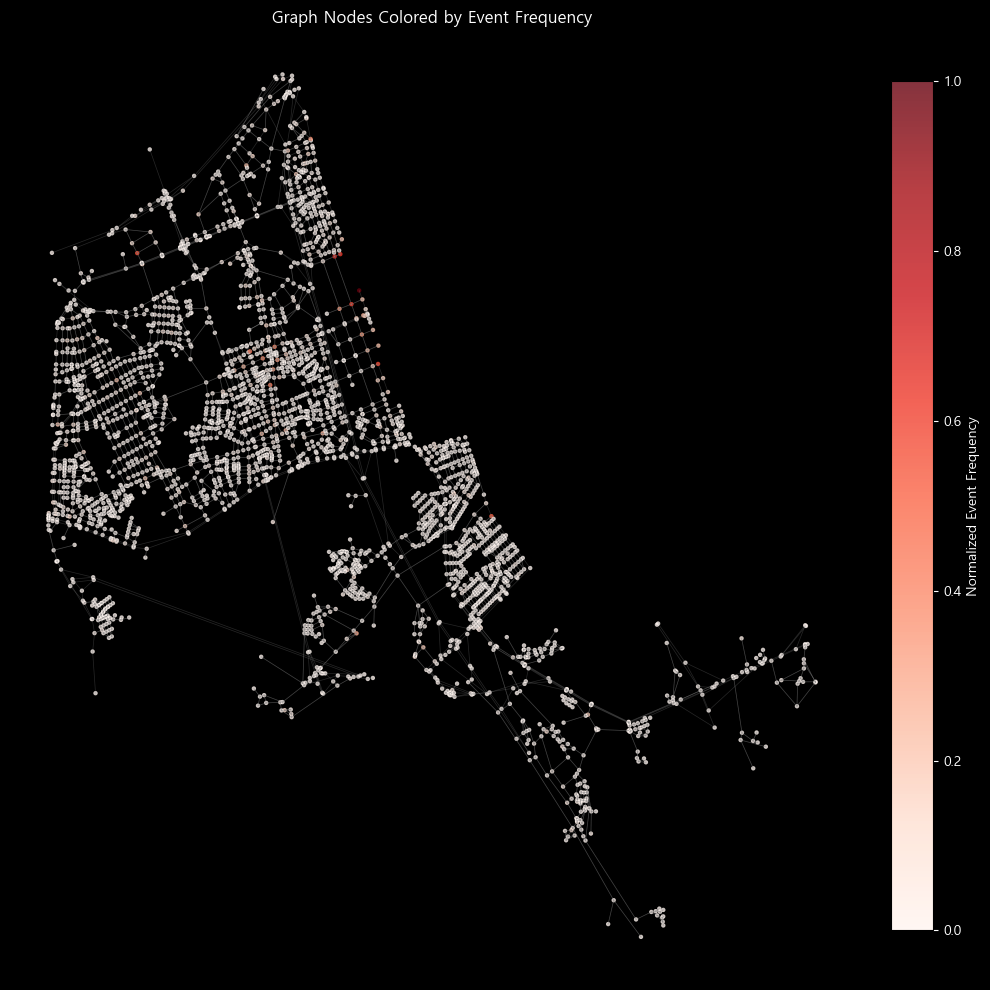

In [23]:
#### 시각화 #####

# ——— 2. 노드별 이벤트 수(또는 가중치) 준비 ———
# node_counts: Series(index=node_id, value=event_count)
# 예) node_counts = train_all.groupby("node").size()

# 모든 노드에 대해 0 값 채우기
counts_all = node_counts.reindex(nodes.index, fill_value=0)

# 0–1 정규화
norm_counts = counts_all / counts_all.max()

# ——— 3. 시각화용 위치 및 색상 배열 생성 ———
xs = nodes['x'].values  # 경도
ys = nodes['y'].values  # 위도
colors = norm_counts.values  # 0–1 스케일 값

# ——— 4. 플롯 그리기 ———
fig, ax = plt.subplots(figsize=(10,10), facecolor='k')
ax.set_facecolor('k')

# 4-1. 간선 그리기 (희미한 회색)
for u, v in G.edges():
    x0, y0 = G.nodes[u]['x'], G.nodes[u]['y']
    x1, y1 = G.nodes[v]['x'], G.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5, alpha=0.3)

# 4-2. 노드 그리기 (컬러맵 적용)
scatter = ax.scatter(xs, ys,
                     c=colors,
                     cmap='Reds',
                     s=10,           # 노드 크기
                     marker='o',
                     edgecolors='none',
                     alpha=0.8)

# 4-3. 컬러바
cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Event Frequency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# 4-4. 기타 스타일
ax.set_title('Graph Nodes Colored by Event Frequency', color='white')
ax.axis('off')

plt.tight_layout()
plt.show()


In [3]:
# 전처리

# df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/CCTV기반단속개별건수.csv', encoding='cp949')
df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/일반단속개별건수_geocoded.csv', encoding='cp949')

# datetime 처리
df['단속일시'] = pd.to_datetime(df['단속일시'], errors='coerce')
df = df.dropna(subset=['단속일시', '단속동'])

# 파생 컬럼 생성
df['요일'] = df['단속일시'].dt.day_name()
df['시간대'] = df['단속일시'].dt.hour
df['단속날짜'] = df['단속일시'].dt.date

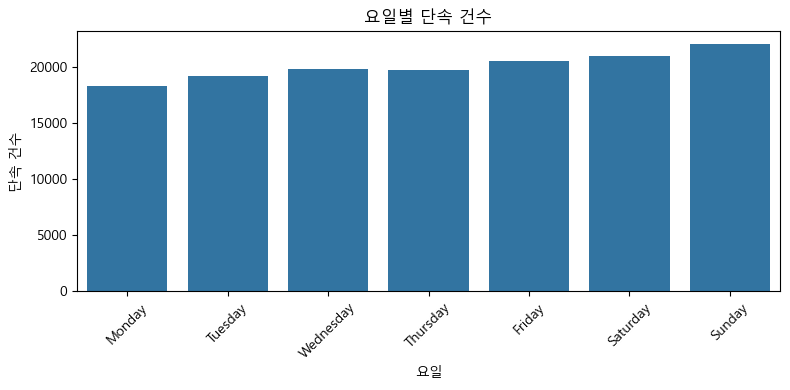

In [4]:
# 요일별 단속빈도 분석

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='요일', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("요일별 단속 건수")
plt.xlabel("요일")
plt.ylabel("단속 건수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

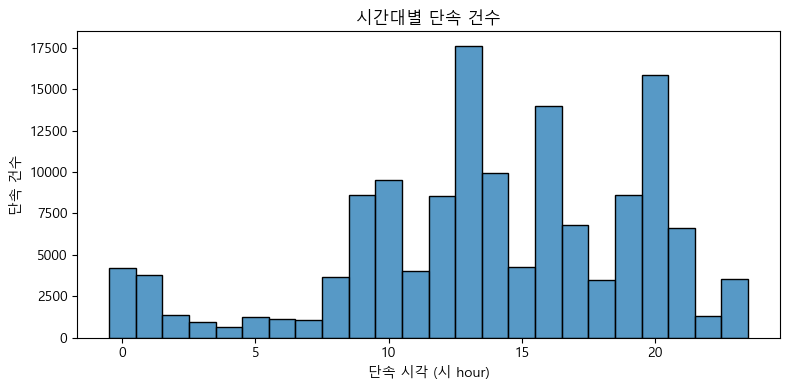

In [5]:
# 시간대별 단속 빈도 분석

plt.figure(figsize=(8,4))
sns.histplot(data=df, x='시간대', bins=24, discrete=True)
plt.title("시간대별 단속 건수")
plt.xlabel("단속 시각 (시 hour)")
plt.ylabel("단속 건수")
plt.tight_layout()
plt.show()


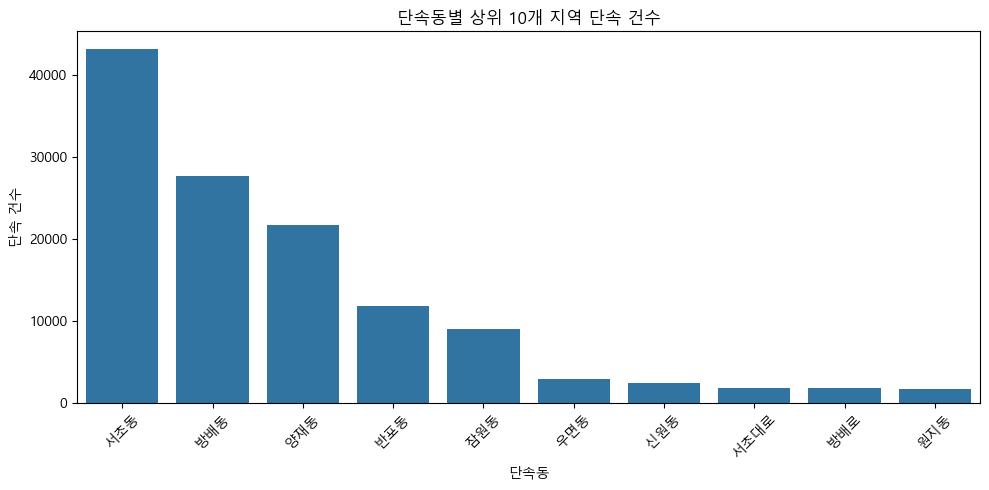

In [6]:
# 지역(단속동)별 단속 빈도 분석

top_dong = df['단속동'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_dong.index, y=top_dong.values)
plt.title("단속동별 상위 10개 지역 단속 건수")
plt.ylabel("단속 건수")
plt.xlabel("단속동")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


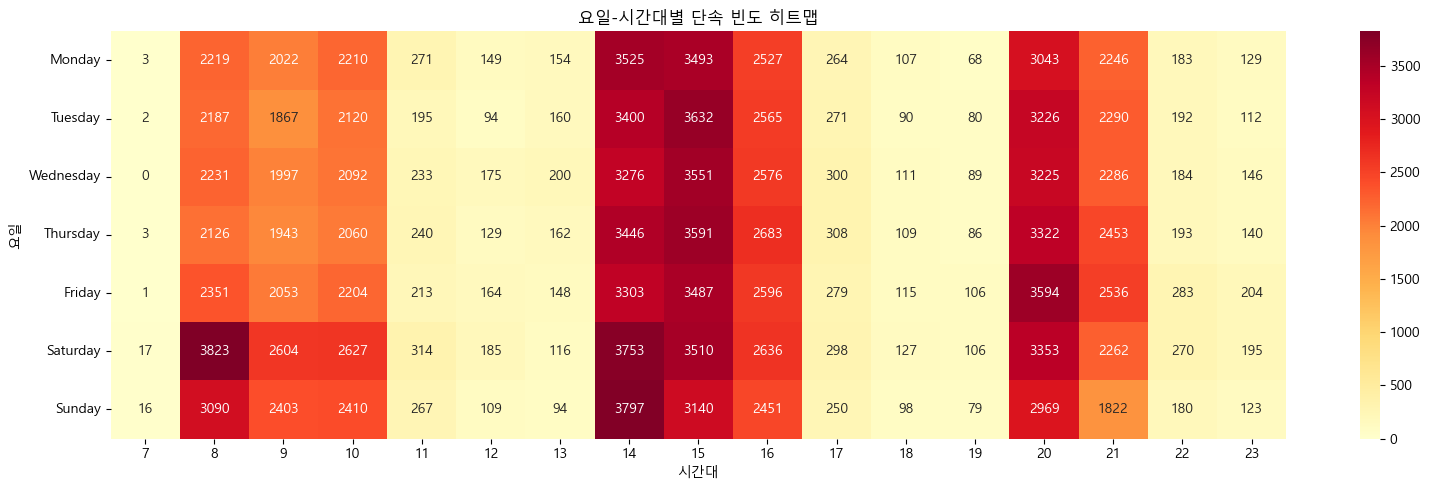

In [82]:
# 요일 - 시간대 히트맵

pivot = df.pivot_table(index='요일', columns='시간대', values='단속날짜', aggfunc='count').fillna(0)
pivot = pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(16, 5))
sns.heatmap(pivot, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title("요일-시간대별 단속 빈도 히트맵")
plt.xlabel("시간대")
plt.ylabel("요일")
plt.tight_layout()
plt.show()
